### In this version of the hexagon spec models, I included a scale factor in the training data, which changes the spacing used in the simulations.

In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

In [2]:
#Load the training data

#energy = (pd.read_csv('HexagonBias_v3.csv', header=None)*1000).round().astype(int)
energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)

energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]

col_names = ['deltaI', 'deltaR', 'scale_factor']+ energy_names

#data = pd.read_csv('HexagonTrainingData052818_specPoints.csv', header = None, names = col_names)
#data = pd.read_csv('HexagonTrainingData060518_v3.csv', header = None, names = col_names)
data = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData060518_v4.csv', header = None, names = col_names)


data.head()


,deltaI,deltaR,scale_factor,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.92540,0.162570,0.151630,0.144180,0.139540,0.137140,0.13665,0.13798,...,1.19620,1.15800,1.12230,1.08920,1.05910,1.03080,1.00580,0.98332,0.96349,0.94655
1,0.91338,-0.57749,0.91951,0.129820,0.120550,0.114190,0.110230,0.108000,0.10734,0.10803,...,1.46230,1.39400,1.32840,1.26580,1.20730,1.15290,1.10220,1.05670,1.01530,0.97832
2,0.27850,-0.71176,1.09150,0.060791,0.065315,0.071834,0.080522,0.092597,0.10939,0.13261,...,0.78962,0.82008,0.86019,0.90906,0.96941,1.04080,1.12380,1.21730,1.32090,1.42990
3,0.96489,-1.32320,1.09410,0.092516,0.098116,0.106220,0.117390,0.132910,0.15339,0.18192,...,0.95044,0.92788,0.91157,0.90112,0.89638,0.89736,0.90418,0.91637,0.93454,0.95788
4,0.95717,-0.80837,1.06010,0.098679,0.101980,0.107370,0.115320,0.126210,0.14079,0.16022,...,1.34080,1.38030,1.42140,1.46150,1.50000,1.53280,1.55750,1.57210,1.57540,1.56660


In [3]:
X = data.drop(['deltaI', 'deltaR','scale_factor'], axis = 1)
Y = data[['deltaI', 'deltaR', 'scale_factor']]

ts1 = 0.3
rs1 = 42

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1 )
data.head()

,deltaI,deltaR,scale_factor,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.92540,0.162570,0.151630,0.144180,0.139540,0.137140,0.13665,0.13798,...,1.19620,1.15800,1.12230,1.08920,1.05910,1.03080,1.00580,0.98332,0.96349,0.94655
1,0.91338,-0.57749,0.91951,0.129820,0.120550,0.114190,0.110230,0.108000,0.10734,0.10803,...,1.46230,1.39400,1.32840,1.26580,1.20730,1.15290,1.10220,1.05670,1.01530,0.97832
2,0.27850,-0.71176,1.09150,0.060791,0.065315,0.071834,0.080522,0.092597,0.10939,0.13261,...,0.78962,0.82008,0.86019,0.90906,0.96941,1.04080,1.12380,1.21730,1.32090,1.42990
3,0.96489,-1.32320,1.09410,0.092516,0.098116,0.106220,0.117390,0.132910,0.15339,0.18192,...,0.95044,0.92788,0.91157,0.90112,0.89638,0.89736,0.90418,0.91637,0.93454,0.95788
4,0.95717,-0.80837,1.06010,0.098679,0.101980,0.107370,0.115320,0.126210,0.14079,0.16022,...,1.34080,1.38030,1.42140,1.46150,1.50000,1.53280,1.55750,1.57210,1.57540,1.56660


## Using the Best Models on the Hexagon Data

### Statsmodels

 
RMSE on test data: 2.890027951815111 for  Delta I
R^2 Score on test data: -101.28501439808423 for Delta I
 
RMSE on test data: 5.88853305594446 for  Delta R
R^2 Score on test data: -166.6511859743473 for Delta R
 
RMSE on test data: 5.88853305594446 for  Delta R Zoomed In
R^2 Score on test data: -166.6511859743473 for Delta R Zoomed In
 
RMSE on test data: 0.08674813687291745 for  Scale Factor
R^2 Score on test data: -1.2525253635472762 for Scale Factor
The average residual for predict: 0.3099
Residual is this percent of predict range 0.16 %
The average residual for predict: 0.4773
Residual is this percent of predict range 0.131 %
The average residual for predict: 0.0067
Residual is this percent of predict range 0.118 %


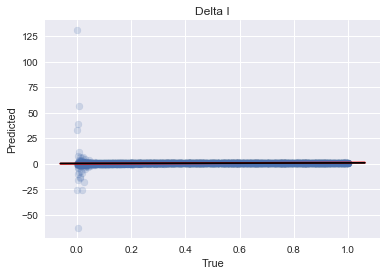

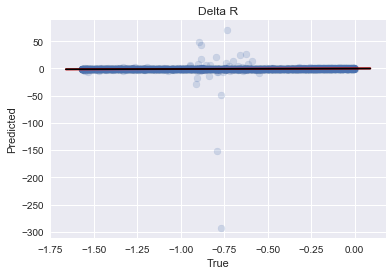

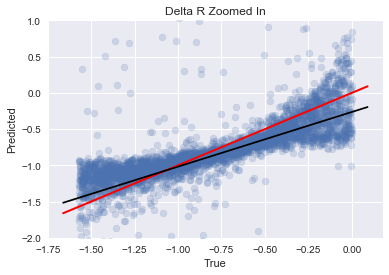

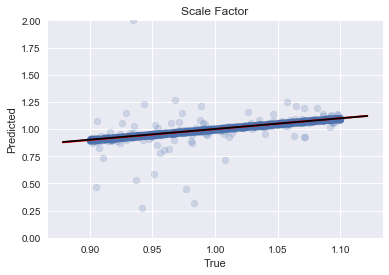

In [4]:
#Initialize and fit OLS model for deltaI 
model_OLS_I = sm.OLS(Y_train['deltaI'], X_train)
model_OLS_R = sm.OLS(Y_train['deltaR'], X_train)
model_OLS_sf = sm.OLS(Y_train['scale_factor'], X_train)

results_OLS_I = model_OLS_I.fit()
results_OLS_R = model_OLS_R.fit()
results_OLS_sf = model_OLS_sf.fit()

#Make predictions on testing data
predictions_OLS_I = results_OLS_I.predict(X_test) # make the predictions by the model
predictions_OLS_R = results_OLS_R.predict(X_test)
predictions_OLS_sf = results_OLS_sf.predict(X_test)

#print(results_OLS_I.summary())
#print(results_OLS_R.summary())

#If we plot the predictions against the test data, a perfect model should be linear


plotSummary(Y_test['deltaI'], predictions_OLS_I,'Delta I')
#ylim([-1,5])
plotSummary(Y_test['deltaR'], predictions_OLS_R, 'Delta R')
plotSummary(Y_test['deltaR'], predictions_OLS_R, 'Delta R Zoomed In')
ylim([-2,1])
plotSummary(Y_test['scale_factor'], predictions_OLS_sf, 'Scale Factor')
ylim([0,2])


myResiduals(Y_test['deltaI'], predictions_OLS_I)
myResiduals(Y_test['deltaR'], predictions_OLS_R)
myResiduals(Y_test['scale_factor'], predictions_OLS_sf)

OLS_R2_sf = r2_score(Y_test['scale_factor'], predictions_OLS_sf)

### Decision Tree

 
RMSE on test data: 0.13524261391046677 for  deltaI Depth 30
R^2 Score on test data: 0.7760066957572385 for deltaI Depth 30
 
RMSE on test data: 0.1993284302605753 for  deltaR Depth 30
R^2 Score on test data: 0.8078984413646915 for deltaR Depth 30
 
RMSE on test data: 0.017589924571178608 for  scale factor - DT
R^2 Score on test data: 0.9073858528026558 for scale factor - DT
 
Regression - Decision Tree -  Score:  0.800113602197019 , using max depth of 30
 
Cross Validation Scores for regressor with max depth of  30  :  [0.82414052 0.83750141 0.83135469 0.82932225 0.84344717 0.8322434
 0.81193488 0.83373576 0.82442025 0.7923106 ]


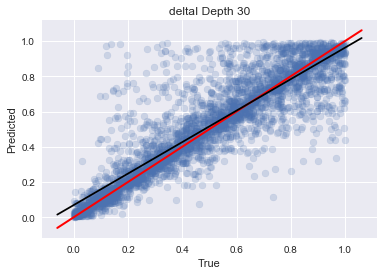

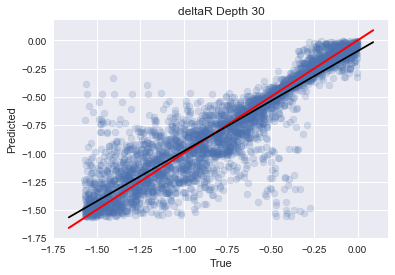

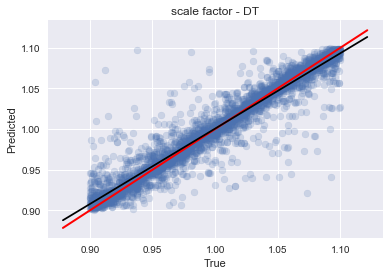

In [5]:
#Initialize the model
rs = 42
regr_DT = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT.fit(X_train, Y_train)


#Print the coefficients or importances

data1 = pd.DataFrame(regr_DT.feature_importances_.T, columns = ['Regr - DT']) 

data1.index = X_train.columns

#print(data1[data1['Regr - DT']>0.001])


#Use model to predict
y_pred_DT = regr_DT.predict(X_test)


#Plot results
plotSummary(Y_test['deltaI'], y_pred_DT[:,0], 'deltaI Depth 30')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], y_pred_DT[:,1], 'deltaR Depth 30')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y_test['scale_factor'], y_pred_DT[:,2], 'scale factor - DT')

DT_R2_sf = r2_score(Y_test['scale_factor'], y_pred_DT[:,2])

print(' ')

#Trying to understand the scoring
print('Regression - Decision Tree -  Score: ', regr_DT.score(X_test,Y_test),', using max depth of 30')
print(' ')
regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print( 'Cross Validation Scores for regressor with max depth of ', regressor.max_depth, ' : ', cross_val_score(regressor, X, Y, cv=10))

## Random Forest


Score - Random Forest: 0.8993279417370635 for delta I/R 10
 
RMSE on test data: 0.10148115573984134 for  deltaI 10
R^2 Score on test data: 0.8738815183755473 for deltaI 10
 
RMSE on test data: 0.13793519951058517 for  deltaR 10
R^2 Score on test data: 0.908009578234853 for deltaR 10
 
RMSE on test data: 0.007351974954224051 for  Scale Factor
R^2 Score on test data: 0.9838207861431069 for Scale Factor


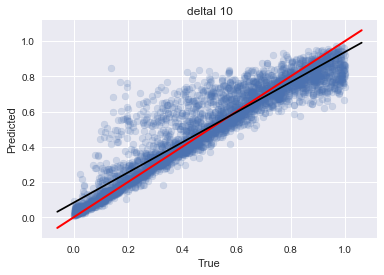

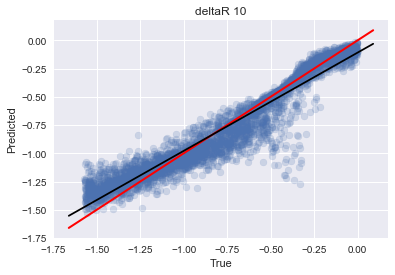

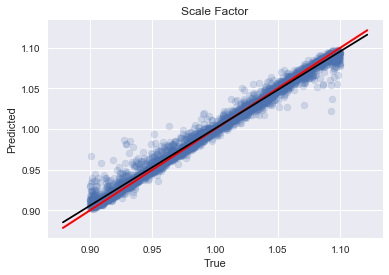

In [6]:
rs = 42
regr_RF = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF = regr_RF.fit(X_train, Y_train)

predict_RF = model_RF.predict(X_test)


importance_RF_10 = pd.Series(model_RF.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF.score(X_test, Y_test), 'for delta I/R 10')


plotSummary(Y_test['deltaI'], predict_RF[:,0], 'deltaI 10')
plotSummary(Y_test['deltaR'], predict_RF[:,1], 'deltaR 10')
plotSummary(Y_test['scale_factor'], predict_RF[:,2], 'Scale Factor')

RF_R2_sf = r2_score(Y_test['scale_factor'], predict_RF[:,2])

## AdaBoost Random Forest

 
RMSE on test data: 0.08239214789435773 for  AdaBoost Delta I
R^2 Score on test data: 0.9168658283846048 for AdaBoost Delta I
 
RMSE on test data: 0.12930167513809007 for  AdaBoost Delta R
R^2 Score on test data: 0.9191647663568101 for AdaBoost Delta R
 
RMSE on test data: 0.0029615996072894905 for  AdaBoost Scale Factor
R^2 Score on test data: 0.9973745601948886 for AdaBoost Scale Factor
Delta I AdaBoost Score: 0.9168658283846048
Delta R AdaBoost Score: 0.9191647663568101
Scale Factor AdaBoost Score: 0.9973745601948885


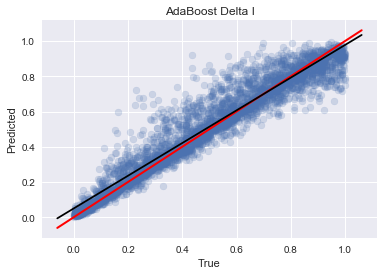

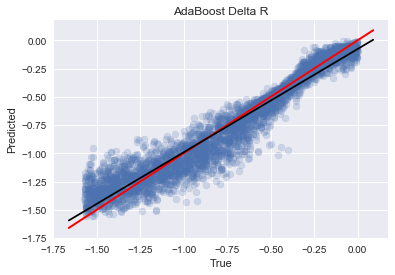

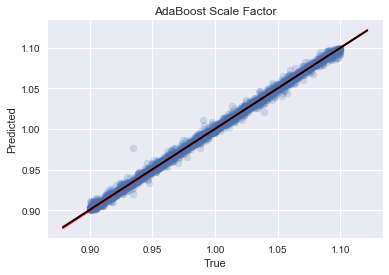

In [7]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_ABR = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

model_AB = regr_AB.fit(X_train, Y_train['deltaI'])
model_AB_R = regr_ABR.fit(X_train, Y_train['deltaR'])
model_AB_sf = regr_AB_sf.fit(X_train, Y_train['scale_factor'])

y_pred_AB1 = model_AB.predict(X_test)
y_pred_AB1_R = model_AB_R.predict(X_test)
y_pred_AB1_sf = model_AB_sf.predict(X_test)


plotSummary(Y_test['deltaI'], y_pred_AB1, 'AdaBoost Delta I')
plotSummary(Y_test['deltaR'], y_pred_AB1_R, 'AdaBoost Delta R')
plotSummary(Y_test['scale_factor'], y_pred_AB1_sf, 'AdaBoost Scale Factor')

print('Delta I AdaBoost Score:', model_AB.score(X_test, Y_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_R.score(X_test, Y_test['deltaR']))
print('Scale Factor AdaBoost Score:', model_AB_sf.score(X_test, Y_test['scale_factor']))

ABRF_R2_sf = r2_score(Y_test['scale_factor'], y_pred_AB1_sf)

## Gradient Boosting Random Forest

In [8]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


regr_GB = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GBR = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)



In [9]:
model_GB = regr_GB.fit(X_train[1:3000], Y_train['deltaI'][1:3000])


In [10]:
model_GB_R = regr_GBR.fit(X_train[1:3000], Y_train['deltaR'][1:3000])


In [11]:
model_GB_sf = regr_GB_sf.fit(X_train[1:3000], Y_train['scale_factor'][1:3000])

 
RMSE on test data: 0.1430689263912966 for  GradientBoost Delta I
R^2 Score on test data: 0.7493321935719972 for GradientBoost Delta I
 
RMSE on test data: 0.23344015223847542 for  GradientBoost Delta R
R^2 Score on test data: 0.7365225140512206 for GradientBoost Delta R
 
RMSE on test data: 0.008017270442068774 for  GradientBoost Scale Factor
R^2 Score on test data: 0.9807601161854504 for GradientBoost Scale Factor
Delta I Gradient Boost Score: 0.7493321935719972
Delta R Gradient Boost Score: 0.7365225140512206
Scale Factor Gradient Boost Score: 0.9807601161854503


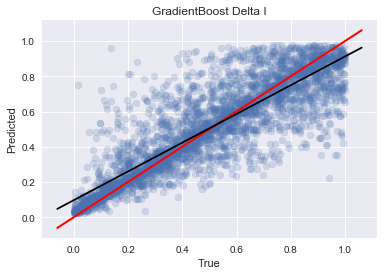

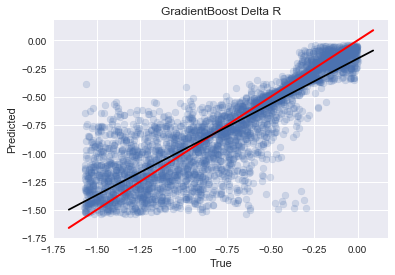

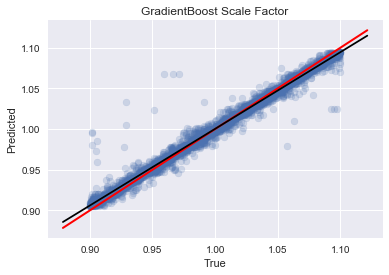

In [12]:
y_pred_GB1 = model_GB.predict(X_test)
y_pred_GB1_R = model_GB_R.predict(X_test)
y_pred_GB1_sf = model_GB_sf.predict(X_test)
 

plotSummary(Y_test['deltaI'], y_pred_GB1, 'GradientBoost Delta I')
plotSummary(Y_test['deltaR'], y_pred_GB1_R, 'GradientBoost Delta R')
plotSummary(Y_test['scale_factor'], y_pred_GB1_sf, 'GradientBoost Scale Factor')

print('Delta I Gradient Boost Score:', model_GB.score(X_test, Y_test['deltaI']))
print('Delta R Gradient Boost Score:', model_GB_R.score(X_test, Y_test['deltaR']))
print('Scale Factor Gradient Boost Score:', model_GB_sf.score(X_test, Y_test['scale_factor']))

GBRF_R2_sf = r2_score(Y_test['scale_factor'], y_pred_GB1_sf)

## Testing the Models on the Experimental Data



In [14]:
# Load the experimental data
exp_data = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData060618_v3.csv', header = None, names = energy_names)

pred_phase_OLS_R = results_OLS_R.predict(exp_data)
pred_phase_OLS_I = results_OLS_I.predict(exp_data)
pred_scale_factor_OLS = results_OLS_sf.predict(exp_data)

pred_phase_DT = regr_DT.predict(exp_data)

pred_phase_RF = regr_RF.predict(exp_data)

pred_phase_AB_R = model_AB_R.predict(exp_data)
pred_phase_AB_I = model_AB.predict(exp_data)
pred_sf_AB = model_AB_sf.predict(exp_data)

pred_phase_GB_I = model_GB.predict(exp_data)
pred_phase_GB_R = model_GB_R.predict(exp_data)
pred_sf_GB = model_GB_sf.predict(exp_data)

predictedPhases = pd.DataFrame(pred_phase_DT, columns = ['deltaI', 'deltaR', 'scale_factor'], index = ['Decision Tree'])

predictedPhases.loc['OLS'] = (pred_phase_OLS_I[0], pred_phase_OLS_R[0], pred_scale_factor_OLS[0])
predictedPhases.loc['Random Forest'] = pred_phase_RF[0]
predictedPhases.loc['AdaBoost'] = (pred_phase_AB_I[0], pred_phase_AB_R[0], pred_sf_AB[0])
predictedPhases.loc['Gradient Boosting'] = (pred_phase_GB_I[0], pred_phase_GB_R[0], pred_sf_GB[0])

predictedPhases['scale_factor_R2'] = (DT_R2_sf, OLS_R2_sf, RF_R2_sf, ABRF_R2_sf, GBRF_R2_sf)

# r2 for phases 
## phase r squared scores 
OLS_iScore = r2_score(Y_test['deltaI'], predictions_OLS_I)
OLS_rScore = r2_score(Y_test['deltaR'], predictions_OLS_R)
DT_iScore = r2_score(Y_test['deltaI'], y_pred_DT[:,0])
DT_rScore = r2_score(Y_test['deltaR'], y_pred_DT[:,1])
RF_iScore = r2_score(Y_test['deltaI'], predict_RF[:,0])
RF_rScore = r2_score(Y_test['deltaR'], predict_RF[:,1])
AB_iScore = model_AB.score(X_test, Y_test['deltaI'])
AB_rScore = model_AB_R.score(X_test, Y_test['deltaR']) 
GB_iScore = model_GB.score(X_test, Y_test['deltaI'])
GB_rScore = model_GB_R.score(X_test, Y_test['deltaR'])

predictedPhases['deltaI_R2'] = (DT_iScore, OLS_iScore, RF_iScore, AB_iScore, GB_iScore)
predictedPhases['deltaR_R2'] = (DT_rScore, OLS_rScore, RF_rScore, AB_rScore, GB_rScore)

predictedPhases

,deltaI,deltaR,scale_factor,scale_factor_R2,deltaI_R2,deltaR_R2
Decision Tree,0.104248,-0.096173,0.931143,0.907386,0.776007,0.807898
OLS,-3.452828,3.151781,0.840257,-1.252525,-101.285014,-166.651186
Random Forest,0.118911,-0.043063,0.964791,0.983821,0.873882,0.908010
AdaBoost,0.073534,-0.028909,0.965290,0.997375,0.916866,0.919165
Gradient Boosting,0.070811,-0.084784,0.962362,0.980760,0.749332,0.736523


## TRAINING A SECOND SET OF MODELS WITH FIRST PREDICTED SCALE FACTOR

Used a scale factor of 0.964 when generating training data

In [ ]:
#Load the training data

#energy = (pd.read_csv('HexagonBias_v3.csv', header=None)*1000).round().astype(int)
energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)

energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]

col_names = ['deltaI', 'deltaR']+ energy_names

#data = pd.read_csv('HexagonTrainingData052818_specPoints.csv', header = None, names = col_names)
#data = pd.read_csv('HexagonTrainingData060518_v3.csv', header = None, names = col_names)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData060618_v5.csv', header = None, names = col_names)


data2.head()

X2 = data2.drop(['deltaI', 'deltaR'], axis = 1)
Y2 = data2[['deltaI', 'deltaR']]

ts1 = 0.3
rs1 = 42

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1 )
data2.head()

### DECISION TREE - JUST PHASE

In [ ]:
#Initialize the model
regr_DT_2 = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2)

#Fit the model
regr_DT_2.fit(X2_train, Y2_train)


#Print the coefficients or importances

data1 = pd.DataFrame(regr_DT_2.feature_importances_.T, columns = ['Regr - DT']) 

data1.index = X2_train.columns

#print(data1[data1['Regr - DT']>0.001])


#Use model to predict
y_pred_DT_2 = regr_DT_2.predict(X2_test)

#Plot results
plotSummary(Y2_test['deltaI'], y_pred_DT_2[:,0], 'deltaI Depth 30')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], y_pred_DT_2[:,1], 'deltaR Depth 30')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y_test['scale_factor'], y_pred_DT[:,2], 'scale factor - DT')

print(' ')

#Trying to understand the scoring
print('Regression - Decision Tree -  Score: ', regr_DT_2.score(X2_test,Y2_test),', using max depth of 30')
print(' ')
regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print( 'Cross Validation Scores for regressor with max depth of ', regressor.max_depth, ' : ', cross_val_score(regressor, X2, Y2, cv=10))

### RANDOM FOREST - JUST PHASE

In [ ]:
rs = 42
regr_RF_2 = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_2 = regr_RF_2.fit(X2_train, Y2_train)

predict_RF_2 = model_RF_2.predict(X2_test)


importance_RF_10_2 = pd.Series(model_RF_2.feature_importances_, index = X2_train.columns)

print('')
print('Score - Random Forest:' , model_RF_2.score(X2_test, Y2_test), 'for delta I/R 10')

plotSummary(Y2_test['deltaI'], predict_RF_2[:,0], 'deltaI 10')
plotSummary(Y2_test['deltaR'], predict_RF_2[:,1], 'deltaR 10')


## TEST EXPERIMENTAL DATA ON SECOND VERSIONS OF MODELS


In [ ]:
# Load the experimental data
exp_data = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData060618_v3.csv', header = None, names = energy_names)


pred_phase_DT_2 = regr_DT_2.predict(exp_data)

pred_phase_RF_2 = regr_RF_2.predict(exp_data)

predictedPhases = pd.DataFrame(pred_phase_DT_2, columns = ['deltaI', 'deltaR'], index = ['Decision Tree'])

predictedPhases.loc['Random Forest'] = pred_phase_RF_2[0]

print(predictedPhases)
predictedPhases.mean()